Soft Computing, Simona Prokić, SW16/2015
Sudoku Solver

In [1]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def gray_image(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def treshold(image):
#     return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 3)
#     return cv2.threshold(image,127,255,cv2.THRESH_BINARY)
#     return cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV)
    return (image > 250) * 255

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
        
def blur_image(image, k_size=3):
    return cv2.blur(image, (k_size,k_size))

def dilate_image(image):
    kernel = np.ones((3, 3))
    return cv2.dilate(image, kernel, iterations=2)

def erode_image(image):
    kernel = np.ones((3, 3))
    return cv2.erode(image, kernel, iterations=1)

def invert_image(image):
    return 255-image

def process_hough_result(result):
    lines = []
    for line in hough_result:
        lines.append(line[0])
        lines = sorted(lines, key=lambda line:line[0])
    return lines

In [3]:
def canny(image, ratio=3, kernel_size=5):
    return cv2.Canny(np.uint8(image), 255/ratio, 255, kernel_size)

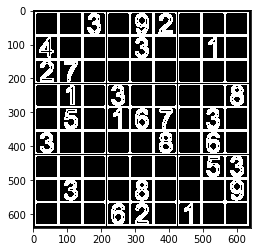

In [4]:
img = load_image('images/sudoku2.png')
image = gray_image(img)
image = blur_image(image)
# image = treshold(image)
# image = invert_image(image)
image = canny(image)
image = dilate_image(image)

display_image(image)



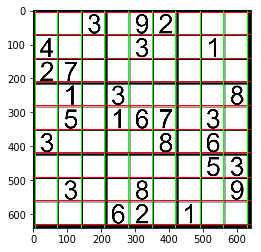

In [5]:
hough_result = cv2.HoughLines(image, 1, np.pi/180, 600)
lines = process_hough_result(hough_result)
final_lines = []

pos_hor = 0
pos_ver = 0
first_hor_line = True
first_ver_line = True

for line in lines:
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    if (not first_hor_line) and (not first_ver_line):
        if b>0.5:
            if rho-pos_hor>10:
                pos_hor = rho
                cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
                final_lines.append([rho, theta, 0])
        else:
            if rho-pos_ver>10:
                pos_ver = rho
                cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
                final_lines.append([rho, theta, 1])
    elif b>0.5:
        if first_hor_line:
            final_lines.append([rho, theta, 0])
            pos_hor = rho
            first_hor_line = False
            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
            continue
    elif b<0.5:
        if first_ver_line:
            final_lines.append([rho, theta, 1])
            pos_ver = rho
            first_ver_line = False
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
            continue
    

cv2.imwrite('houghlines.jpg',img)
image_lines = load_image('houghlines.jpg')
display_image(image_lines)

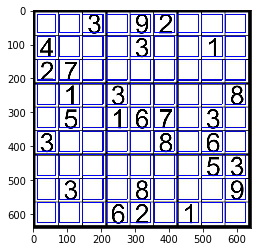

In [8]:
points = []
for hor_line in final_lines:
    if hor_line[2] == 0:
        for ver_line in final_lines:
            if ver_line[2] == 1:
                rho1, theta1 = hor_line[0], hor_line[1]
                rho2, theta2 = ver_line[0], ver_line[1]
                xy = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
                rho = np.array([rho1,rho2])
                result = np.linalg.solve(xy, rho)
                points.append(result)

if len(points) == 100:
    img = load_image('images/sudoku2.png')
    for i in range(0,9):
        for j in range(0,9):
            y1=int(points[j+i*10][1]+5)
            y2=int(points[j+i*10+11][1]-5)
            x1=int(points[j+i*10][0]+5)
            x2=int(points[j+i*10+11][0]-5)
            cv2.rectangle(img,(x1,y1),(x2, y2),(255,0,0),2)
            cv2.imwrite('rectangles.jpg',img)
            image_rectangles = load_image('rectangles.jpg')
            display_image(image_rectangles)